In [1]:
# base data sci libraries
import os
import pywt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.stats import moment

# image processing libraries
import cv2
from PIL import Image
from scipy import ndimage

# sklearn for pipeline creation and grid-search cv
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# BELOW ONLY NEEDED IF WE GO WITH THE IMPLEMENTATION OF A CNN, BUT I THINK THAT WOULD BE OVER THE TOP FOR THIS TASK
# ! pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras import layers, models

np.random.seed(23)
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
sns.set()

### To-Dos
* Finalize feature selections & tune features
* Once we have features, tweak and play with the grid-search CV to get some baseline results for our model
* tSNE


### Done
* Add feature functions into cell with extract_log_features() mimicking the format and the instructions there
* Update parse_data() to include any features generated from the functions defined in the featurize block
* Add PCA and any other data exploration we want to complete for feature selection
* Decide on strategy in terms of flattening images or using scalar features -- what is worth spending computational umph on based on data exploration? - NO ?
* Run PCA on existing features 
* Pickle the feature df


### FEATURIZE

In [3]:
def extract_log_features(image_array, sigma=0.7, scalar=True):
    """
    Extract Laplacian of Gaussian (LoG) features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        sigma (float): The sigma value for the Gaussian filter. Controls the amount of smoothing.
        
    Returns:
        numpy.ndarray: The LoG filtered image as a feature vector.
    """
    # apply Laplacian of Gaussian filter
    log_image = ndimage.gaussian_laplace(image_array, sigma=sigma)

    if scalar:
        
        # OPTION 1
        # feature scalar: the sum of absolute values in the LoG image (a simple measure of edginess)
        feature_scalar = np.sum(np.abs(log_image))

        return feature_scalar

    else:
        # OPTION 2
        # feature vector: flatten the LoG image to use as a feature vector directly
        feature_vector = log_image.flatten()

        return feature_vector

In [21]:
def extract_hog_features(image_array, orientation, pixels, scalar=True):
    """
    Extract HOG features from an image array.
    
    Parameters:
        image_array (numpy.ndarray): The input image array.
        saclar: if the output must be a scalar or a feature vector
        
    Returns:
        numpy.ndarray: The HOG as a list of scalars or a feature vector.
    """
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    # convert to grayscale
    else:
        img = image_array
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    
    #HOG feature extraction
    #the orientation and pixels will increase the detail (more orientations and less pixels are more computationally expensive)
    feature_vector = hog(gray_img, orientations=orientation, pixels_per_cell=(pixels, pixels), visualize=False, feature_vector=True)  
    if scalar:
        feature_scalar_ls = []
        feature_scalar_ls.extend([np.mean(feature_vector), #np.mean is for averaging features
                               np.sum(feature_vector), # Overall "strength" or "intensity" of the features
                               np.var(feature_vector),  # Variance
                               moment(feature_vector, moment=3), # Skewness
                               moment(feature_vector, moment=4)]) # Kurtosis
                
        return feature_scalar_ls
    else:
        return feature_vector

In [36]:
def extract_normals_features(image_array, scalar=True):
    #preprocessing
    # convert to floating point image with intensity [0, 1]
    if np.max(image_array) > 1:
        img = image_array.astype(np.float32) / 255.0
    else:
        img = image_array
    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)
    gray_img = img
    # Compute gradients using Sobel operator
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)

    # Compute normal vectors Nx, Ny, Nz
    norm = np.sqrt(sobel_x**2 + sobel_y**2 + 1e-6)
    nx = sobel_x / norm
    ny = sobel_y / norm
    nz = 1 / norm

    # Concatenate nx, ny, nz along a new axis, and flatten it to form a 1D feature vector
    feature_vector = np.stack((nx, ny, nz), axis=-1).reshape(-1)
    if scalar:
        feature_scalar = np.sum(feature_vector)
        return feature_scalar
    else:
        return feature_vector

In [6]:
# More on Gabor: https://medium.com/@anuj_shah/through-the-eyes-of-gabor-filter-17d1fdb3ac97

def extract_gabor_features(image_array, frequency=0.6, theta=0, sigma=1.0, scalar=True):
    """
    Extract Gabor features from an image array.

    Parameters:
        image_array (numpy.ndarray): Input image array.
        frequency (float): Controls width of strips of Gabor function. Decreasing wavelength produces thinner stripes
        theta (float): Orientation of the Gabor kernel in radians.
        sigma (float): Standard deviation of kernel in both x and y directions (isotropic).

    Returns:
        numpy.ndarray: Gabor-filtered image as a feature (scalar or vector).
    """
    # Create Gabor kernel
    kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)) # NOTE: Adjust sigma_x or sigma_y if want anisotropic

    # Apply Gabor kernel to image
    gabor_image = np.abs(ndimage.convolve(image_array, kernel, mode='wrap'))

    if scalar:
        # OPTION 1
        # Feature scalar: sum of values in Gabor filtered image
        feature_scalar = np.sum(gabor_image)
        return feature_scalar
    else:
        # OPTION 2
        # Feature vector: flatten Gabor filtered image to use as feature vector directly
        feature_vector = gabor_image.flatten()
        return feature_vector

In [7]:
# More on BoVW: https://rlrocha.medium.com/bag-of-visual-words-applied-to-image-classification-64a7de0b6369
# And Pyramid Histogram of Visual Words: https://slazebni.cs.illinois.edu/publications/pyramid_chapter.pdf

def extract_bovw_features(image_array, n_clusters=5, scalar=True):    
    """
    Extract Bag of Visual Words (BoVW) features from an image array.

    Parameters:
    image_array (numpy.ndarray): Input image array.
    codebook (numpy.ndarray): Visual vocabulary for quantization.
    patch_size (tuple): Size of the image patches to extract (height, width).

    Returns:
    numpy.ndarray: BoVW representation as a feature (scalar or vector).
    """
    # Detect and compute local features w/ SIFT
    
    detector = cv2.SIFT_create()
    keypoints, descriptors = detector.detectAndCompute(image_array, None)

    if descriptors is None:
        # Handle case when no keypoints are detected
        if scalar:
            return 0
        else:
            return np.zeros(n_clusters)

    # Create visual vocabulary (codebook)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(descriptors)
    codebook = kmeans.cluster_centers_

    # Quantize local features to nearest visual word
    labels = kmeans.predict(descriptors)

    # Create BoVW histogram
    bovw_hist, _ = np.histogram(labels, bins=np.arange(n_clusters + 1), density=True)

    if scalar:
        # OPTION 1
        # Feature scalar: sum of values in the BoVW histogram
        feature_scalar = np.sum(bovw_hist)
        return feature_scalar
    else:
        # OPTION 2
        # Feature vector: BoVW histogram
        feature_vector = bovw_hist
        return feature_vector

In [8]:
# More on Wavelet: https://medium.com/@shouke.wei/basic-concepts-of-wavelets-transform-43830a68ac34

def extract_wavelet_features(image_array, wavelet='haar', level=1, scalar=True):
    """
    Extract wavelet transform features from image array.
    
    Parameters:
        image_array (numpy.ndarray): Input image array.
        wavelet (str): Type of wavelet to be used. 
            Doc: https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html
            And: https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html
        level (int): Level of decomposition in wavelet transform.
        
    Returns:
        numpy.ndarray: Wavelet feature as a vector or scalar.
    """
    # apply wavelet transform
    coeffs = pywt.wavedec2(image_array, wavelet, level=level)

    if scalar:
        # compute mean, variance, skewness, and kurtosis from wavelet coefficients
        cA, cD = coeffs[0], coeffs[1:]
        feature_scalar_ls = []
        feature_scalar_ls.extend([np.mean(cA), np.var(cA), np.mean(cD), np.var(cD)])
        

        return feature_scalar_ls
    else:
        # return wavelet coefficients as a flattened feature vector
        feature_vector = np.concatenate([c.flatten() for c in coeffs])
        return feature_vector


In essence, each image needs to be represented as a feature vector. In the D200 example, the photos of the clothing items were in grayscale and then normalized and then reshaped using `train_images_vectors = np.reshape(train_images, (len(train_images), -1))` where train images is an array of n 28 x 28 training images (i.e. train_images.shape = (n, 28, 28)). After each image is reshaped, the vector is 1 x 784 (i.e. 28 x 28).

We need a dataframe at the end of the day, where each row represents an image and its features. I want to talk more about which features we are actually going to leverage and use as a team, but for right now, I will build the plumbing to be able to run a classification once we actually have the features using the 'full image' technique employed in D200. In our case the images are still 200 x 200.

### Parse Data to DF + Add In Features

In [28]:
def parse_all(folder_path):
    """ 
    Run all feature functions and create df of all feature representations. Scalar or Vector 
    
    Returns: 
        X (np.array): Feature values 
        Y (np.array): Categorical label for each image  
        unique_ids (np.array): image IDs  
    """

    image_vectors = []  # image data
    labels = []  # labels
    ids = []  # unique IDs
    features = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            parts = filename.split('_')
            fabType = parts[0]
            id1 = parts[1]
            id2 = parts[3].split('.')[0]  # Remove .png extension
            
            unique_id = id1 + id2

            image = Image.open(os.path.join(folder_path, filename)).convert('L')
            img_array = np.array(image)
            
            # normalize the image vector to be between 0 and 1 
            img_array_std = (img_array - np.mean(img_array)) / np.std(img_array)

            ### SCALAR FEATURES ###
            hog_stats = extract_hog_features(img_array_std, 4, 20)
            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt = hog_stats[:5]
            wavelet_stats = extract_wavelet_features(img_array_std)
            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD = wavelet_stats[:4]
            
            scalar_features = []
            scalar_features.extend([
                            extract_log_features(img_array_std),    
                            extract_normals_features(img_array_std), 
                            extract_gabor_features(img_array_std),
                            extract_bovw_features(img_array_std),
                            hog_mean, hog_sum, hog_var, hog_skew, hog_kurt,
                            wave_mean_cA, wave_var_cA, wave_mean_cD, wave_var_cD
                            ])
            
            scalar_features_array = np.array(scalar_features)

            """
            
            ### VECTORIZED FEATURES ###
            # new_vector_with_scalar = np.append(img_vector_normalized, log_scalar)

            # log_vector = extract_log_features(img_array, scalar=False)
            # hog_vector = extract_hog_features(img_array, 4, 20, scalar=False)
            # normals_vector = extract_normals_features(img_array, scalar = False)
            
            #NOTE: This is created but then not used, I added as an additional output (features)  
            # final_img_feature_vector  = np.concatenate((img_vector_normalized, scalar_features_array, log_vector, hog_vector, normals_vector)) # BE SURE TO ADD ANY FEATURE VECTORS HERE

            # final_img_feature_vector  = np.concatenate((img_vector_normalized, scalar_features_array)) # flattened image vector + scalar features
            # image_vectors.append(img_vector_normalized)
            # features.append(final_img_feature_vector)
                 
            """

            image_vectors.append(scalar_features_array)
            labels.append(fabType)
            ids.append(unique_id)

    X = np.array(image_vectors)
    Y = np.array(labels)
    unique_ids = np.array(ids)
    # features_array = np.array(features)
    # return X, Y, unique_ids, features_array
    return X, Y, unique_ids

In [29]:
# Driver for PARSE ALL 
folder_path = './Subsamples/train'
# X, Y, unique_ids, features_array = parse_all(folder_path)
X, Y, unique_ids = parse_all(folder_path)

df = pd.DataFrame(X)
df['category'] = pd.Categorical(Y)
df['label'], _ = pd.factorize(df['category'])
df['uid'] = unique_ids
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,category,label,uid
0,3441.793288,2.028531e+07,1844.056770,0.150226,346.120911,0.005210,0.000093,0.000063,2.273737e-16,3.959789,0.001433,0.013402,Blended,0,8821c
1,7211.992783,7.747671e+06,2271.840993,0.151475,348.998260,0.004833,-0.000067,0.000038,2.046363e-16,3.864560,-0.000588,0.045146,Denim,1,1503c
2,8856.756862,5.854463e+06,1967.259618,0.160454,369.684998,0.002032,-0.000002,0.000008,9.094947e-17,3.812086,0.002041,0.062634,Polyester,2,16132c
3,7018.112788,7.817569e+06,1953.124972,0.152300,350.899200,0.004582,0.000011,0.000034,-6.821210e-17,3.879019,0.000541,0.040327,Blended,0,3621d
4,7932.263905,6.971318e+06,2053.412469,0.157971,363.965454,0.002823,-0.000003,0.000017,-4.547474e-16,3.838197,-0.001895,0.053931,Cotton,3,2333a


### 🥒 PICKLE🚰📈

In [31]:
## Pickle the dataframe
# curr_date = 04dd # Replace dd with date 
# filename = f'./Subsamples/train_11_scalar-{curr_date}.pkl'
# df.to_pickle(filename)

# Open the pickled df  
filename = './Subsamples/train_11_scalar-0401.pkl'
df = pd.read_pickle(filename)

In [32]:
#reorder 
train_df = df
train_df.columns = train_df.columns.astype(str)
PIXEL_COLS = train_df.columns.tolist()[:-3] # list of pixel header
LABEL_COLS = ['label', 'category'] # list of labels header

cols_reorder = LABEL_COLS + PIXEL_COLS
train_df = train_df[cols_reorder]
train_df.head()

,label,category,0,1,2,3,4,5,6,7,8,9,10,11
0,0,Blended,3441.793288,2.028531e+07,1844.056770,0.150226,346.120911,0.005210,0.000093,0.000063,2.273737e-16,3.959789,0.001433,0.013402
1,1,Denim,7211.992783,7.747671e+06,2271.840993,0.151475,348.998260,0.004833,-0.000067,0.000038,2.046363e-16,3.864560,-0.000588,0.045146
2,2,Polyester,8856.756862,5.854463e+06,1967.259618,0.160454,369.684998,0.002032,-0.000002,0.000008,9.094947e-17,3.812086,0.002041,0.062634
3,0,Blended,7018.112788,7.817569e+06,1953.124972,0.152300,350.899200,0.004582,0.000011,0.000034,-6.821210e-17,3.879019,0.000541,0.040327
4,3,Cotton,7932.263905,6.971318e+06,2053.412469,0.157971,363.965454,0.002823,-0.000003,0.000017,-4.547474e-16,3.838197,-0.001895,0.053931


### PCA

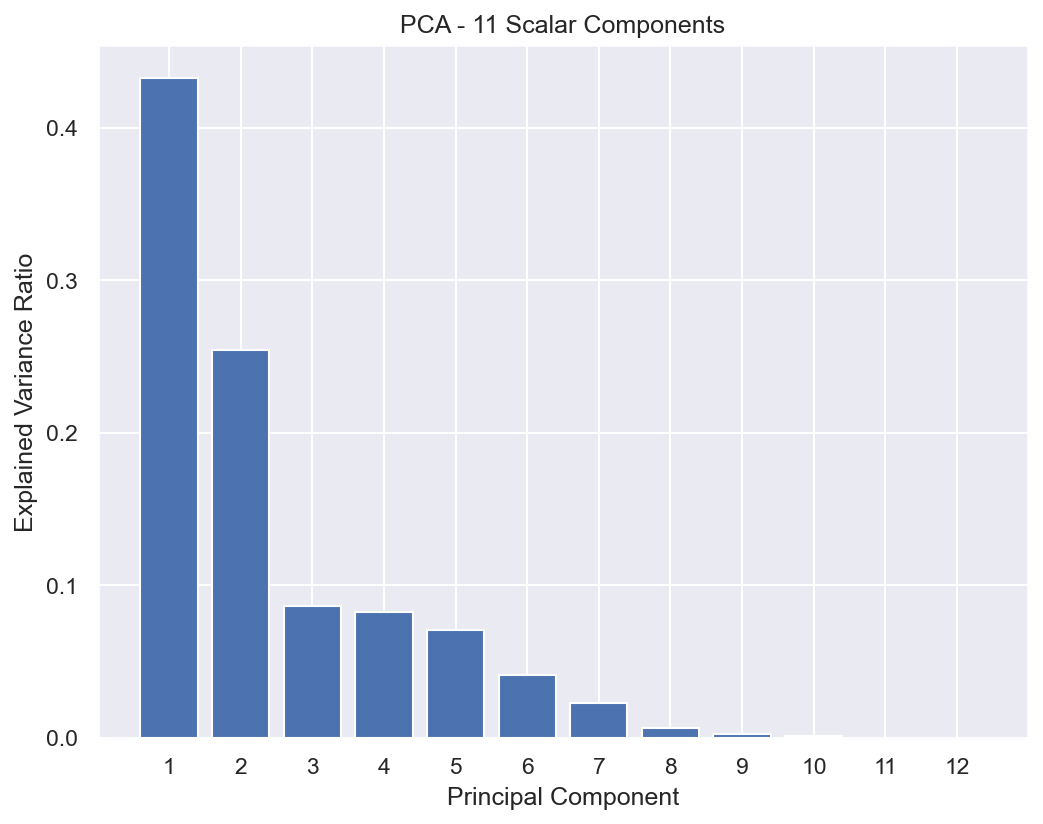

In [35]:
# isolate the feature columns 
features = train_df.iloc[:, 2:]

# standardize the features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# perform PCA
pca = PCA()
pca.fit(features_scaled)

# create a scree plot (explained variance ratios)
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA - 11 Scalar Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))  # Ensure x-ticks for each component
plt.show()

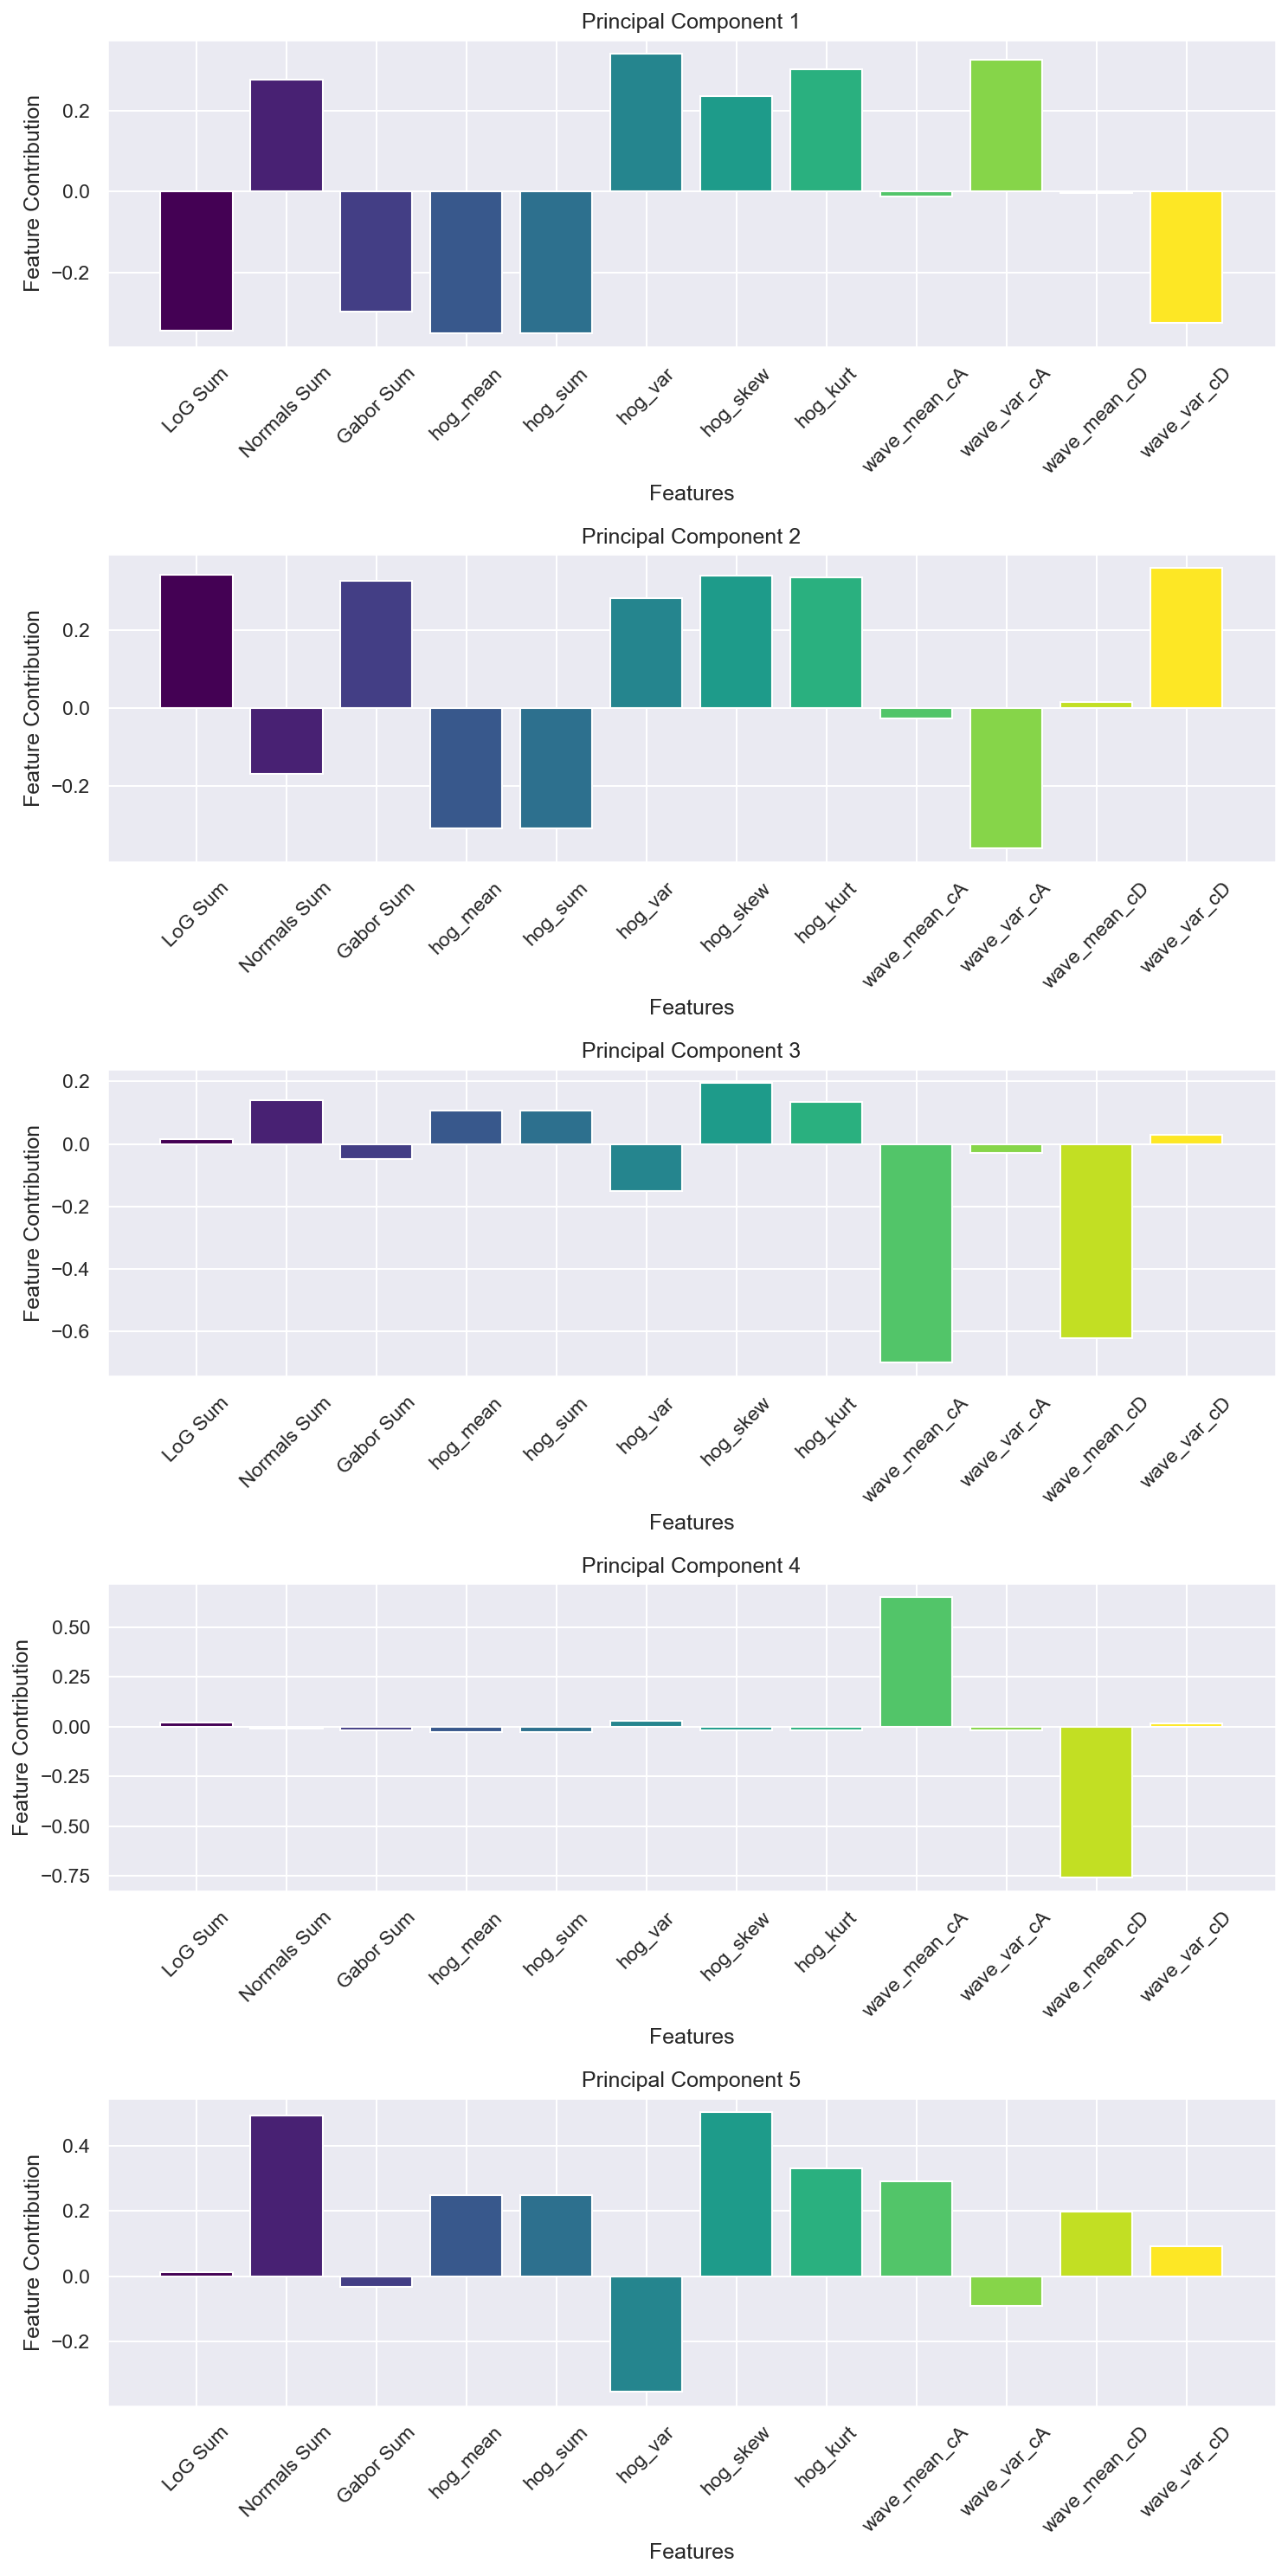

In [38]:
# Assuming 'pca' is your fitted PCA object from sklearn and 'feature_names' are your original feature names
# Let's say there are N features
N = len(pca.components_[0])
feature_names = ['LoG Sum',
                 'Normals Sum',
                 'Gabor Sum',
                 'BoVW Sum',
                 'hog_mean', 
                 'hog_sum', 
                 'hog_var', 
                 'hog_skew', 
                 'hog_kurt',
                 'wave_mean_cA', 
                 'wave_var_cA', 
                 'wave_mean_cD', 
                 'wave_var_cD'
                 ]

# Number of components to display
num_components = 5

colors = plt.cm.viridis(np.linspace(0, 1, N))

fig, axs = plt.subplots(num_components, 1, figsize=(10, num_components * 4))

# Iterate over the first 5 principal components
for i in range(num_components):
    # Get the component
    component = pca.components_[i]
    
    # Create a bar plot for each component's feature contributions
    axs[i].bar(feature_names, component, color=colors)
    axs[i].set_title(f'Principal Component {i+1}')
    axs[i].set_ylabel('Feature Contribution')
    axs[i].set_xlabel('Features')
    axs[i].tick_params(axis='x', rotation=45)  # Rotate feature names for readability

plt.tight_layout()
plt.show()


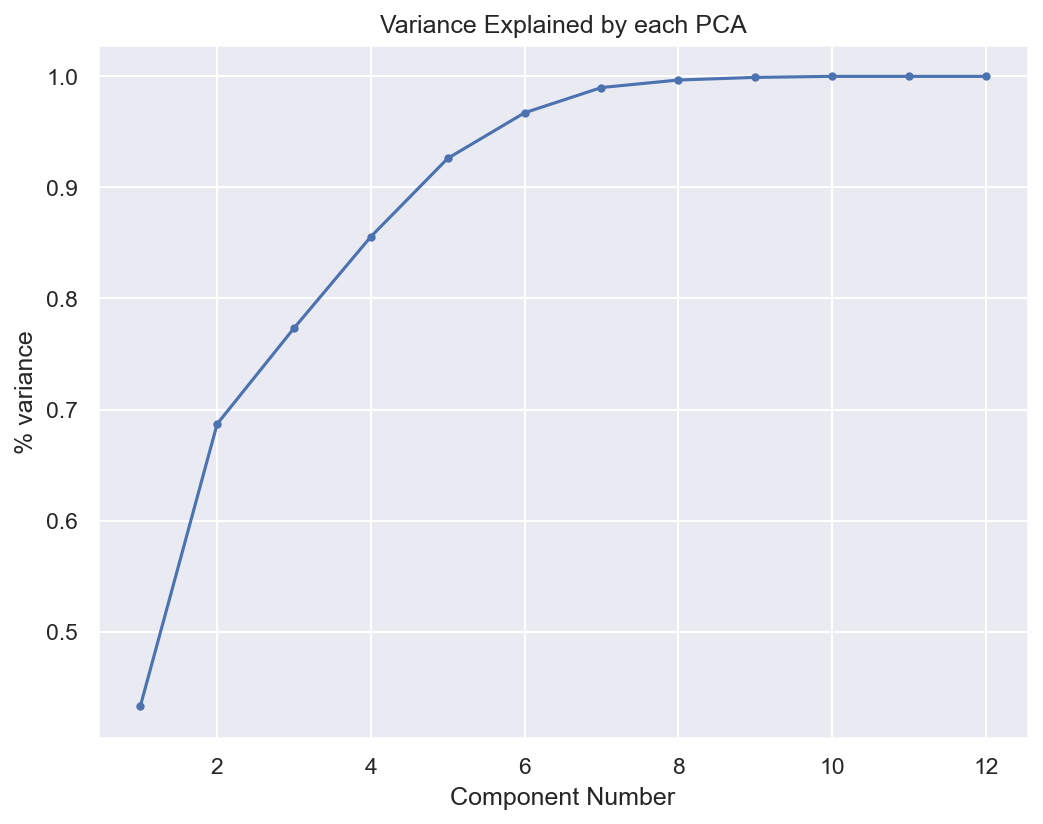

In [42]:
# PC1, PC2 component scores
print(f"Sum of first 2 components: {np.sum(pca.explained_variance_ratio_[:2])}")

variances = pca.explained_variance_ratio_

cumulatives = [] 

for i in range(len(variances)):
    if i == 0:
        cumulative = variances[i]  # For the first element, cumulative sum is the variance itself
    else:
        cumulative += variances[i]  # Accumulate the current variance to the previous cumulative sum
    cumulatives.append(cumulative)

cumulatives
# plot the explained variance (here we have to do it in the opposite side)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(N)+1,
         cumulatives,
         marker='.');
plt.ylabel("% variance")
plt.xlabel("Component Number")
plt.title("Variance Explained by each PCA")
plt.show()

### SVM - Multi-Class Classifier


The function below takes in a test DF, features (which we can modified in the event we have thousands of columns and they are named numerically -- in this case we just need to drop the target variable to define X). It runs cross validation to determine the best hyperparameters to be used for the support vector machine model, returning a grid search object with the following attributes (per ChatGPT):

<b>Attributes</b>
* best_estimator_: The estimator that was chosen by the search, i.e., the estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if refit=False.
* best_score_: The score of the best_estimator on the left out data.
* best_params_: The parameter setting that gave the best results on the hold out data.
* best_index_: The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
* cv_results_: A dictionary with keys as column headers and values as columns, that can be imported into a pandas DataFrame. This attribute provides scores, fit times, score times, and parameters for all the candidate models. It contains a lot of detailed information for each parameter combination that was evaluated.
* scorer_: The function or a dictionary of functions that scores the predictions on the test set.
* n_splits_: The number of cross-validation splits (folds/iterations).
* refit_time_: Time for refitting the best estimator on the whole dataset (available only if refit is set to True).

<b>Methods</b>
* fit(X, y=None, groups=None): Run fit with all sets of parameters.
* predict(X): Call predict on the estimator with the best found parameters.
* score(X, y=None): Returns the score on the given data, if the estimator has been refit.
* predict_proba(X): Call predict_proba on the estimator with the best found parameters, if available.
* decision_function(X): Call decision_function on the estimator with the best found parameters, if available.
* transform(X): Call transform on the estimator with the best found parameters, if available.
* inverse_transform(X): Call inverse_transform on the estimator with the best found parameters, if available.

In [26]:
def svm_grid_search_cv(dataframe, features, target, cv_folds=5):
    """
    Perform grid search cross-validation for SVM classifier on the given dataframe.
    
    Parameters:
    - dataframe: The pandas DataFrame containing the dataset.
    - features: List of column names to be used as features.
    - target: The name of the column to be used as the target variable.
    - cv_folds: Number of folds for cross-validation.
    
    Returns:
    - grid_search: The fitted GridSearchCV object.
    """
    
    # Separate the features and the target variable
    X = dataframe[features]
    y = dataframe[target]
    
    # Split the data into training and testing sets (optional, could also perform CV on the entire dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define a pipeline that includes scaling and the classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling is important for SVM
        ('svm', SVC(probability=True))  # SVM classifier
    ])
    
    # Parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [0.1, 1, 10],  # SVM regularization parameter
        'svm__kernel': ['linear', 'rbf'],  # Kernel type to be used in the algorithm
        'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=1)
    
    # Perform grid search cross-validation
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    
    # Optionally, evaluate on the test set
    test_score = grid_search.score(X_test, y_test)
    print("Test set score: {:.2f}".format(test_score))
    
    return grid_search


### Convolutional Neural Network

The below code has not been tested or debugged - it was read through against a TDS article for accuracy, but it would need significant work, change in approach (and potentially additional compute) if we are to make it work. I wanted to store it so I don't lose the information though!

In [ ]:
# simple cnn model
# def create_cnn_model(input_shape, num_classes):
#     model = models.Sequential([
#         # convolutional layer with ReLU activation and Max Pooling
#         layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         layers.MaxPooling2D((2, 2)),
        
#         # convolutional layer 2
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         # flatten the output and add dense layers for classification
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
    
#     return model

# input_shape = (64, 64, 3)  # input shape (height, width, channels)
# num_classes = 5

# model = create_cnn_model(input_shape, num_classes)

# # compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# # train_images, train_labels = ... 
# # val_images, val_labels = ... 

# train model
# history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))


In [ ]:
## TODO - ADD SVM CODE